# Adversarial Examples

In this notebook we are going to find adversarial examples to fool popular pretrained machine learning models.
This is neither hard nor new, just interesting. Also, coding them up in Python helps me to understand these algorithms better.

Since we can visualize images the best, we are going to start with that. In the future we will add aversarial examples for other use-cases, e.g. speech recognition.

## The method

We are going to use one of the most popular methods for generating adversarial examples: Fast Gradient Sign Method (FGSM).
Read the orignal paper [here](https://arxiv.org/abs/1412.6572).

The method consists of finding a change $\delta$ for our input $x$ that causes our model $f(x)$ to classify $x$ wrong. The challange, and this is true for most methods in this area, lies in finding the correct $\delta$ for this task.

FGSM solves this by finding $\delta = \epsilon * \text{sign}(\nabla_{x} L(x,y; \theta)$.

## The Image Classification Model.

In this task we are going to use a popular, pretrained model for image classification: AlexNet.

In [122]:
import torchvision.models as models

# downloads the weights for the AlexNet (233Mb)
model = models.alexnet(pretrained=True)

### Dataset for Images
Unfortunately, not all ImageNet images are available anymore (and we don't really need them). So here we have downloaded several images and a textfile corresponding the labels for each class (taken from [here](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt)).

In [9]:
with open('./data/imagenet_labels.txt','r') as labelstext:
    labels = eval(labelstext.read())

### Preprocessing

We will have to apply some light preprocessing so our model can work with the image

In [129]:
from torchvision import transforms
from PIL import Image
filename = './data/samples/dog.jpg'
input_image = Image.open(filename)

# standard preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
image_batch = input_tensor.unsqueeze(0) # get a batch, here it's only 1 at a time

In [133]:
pred.argmax()

tensor(698)

In [131]:
pred = model(input_batch)
labels[int(pred.argmax())]

'palace'

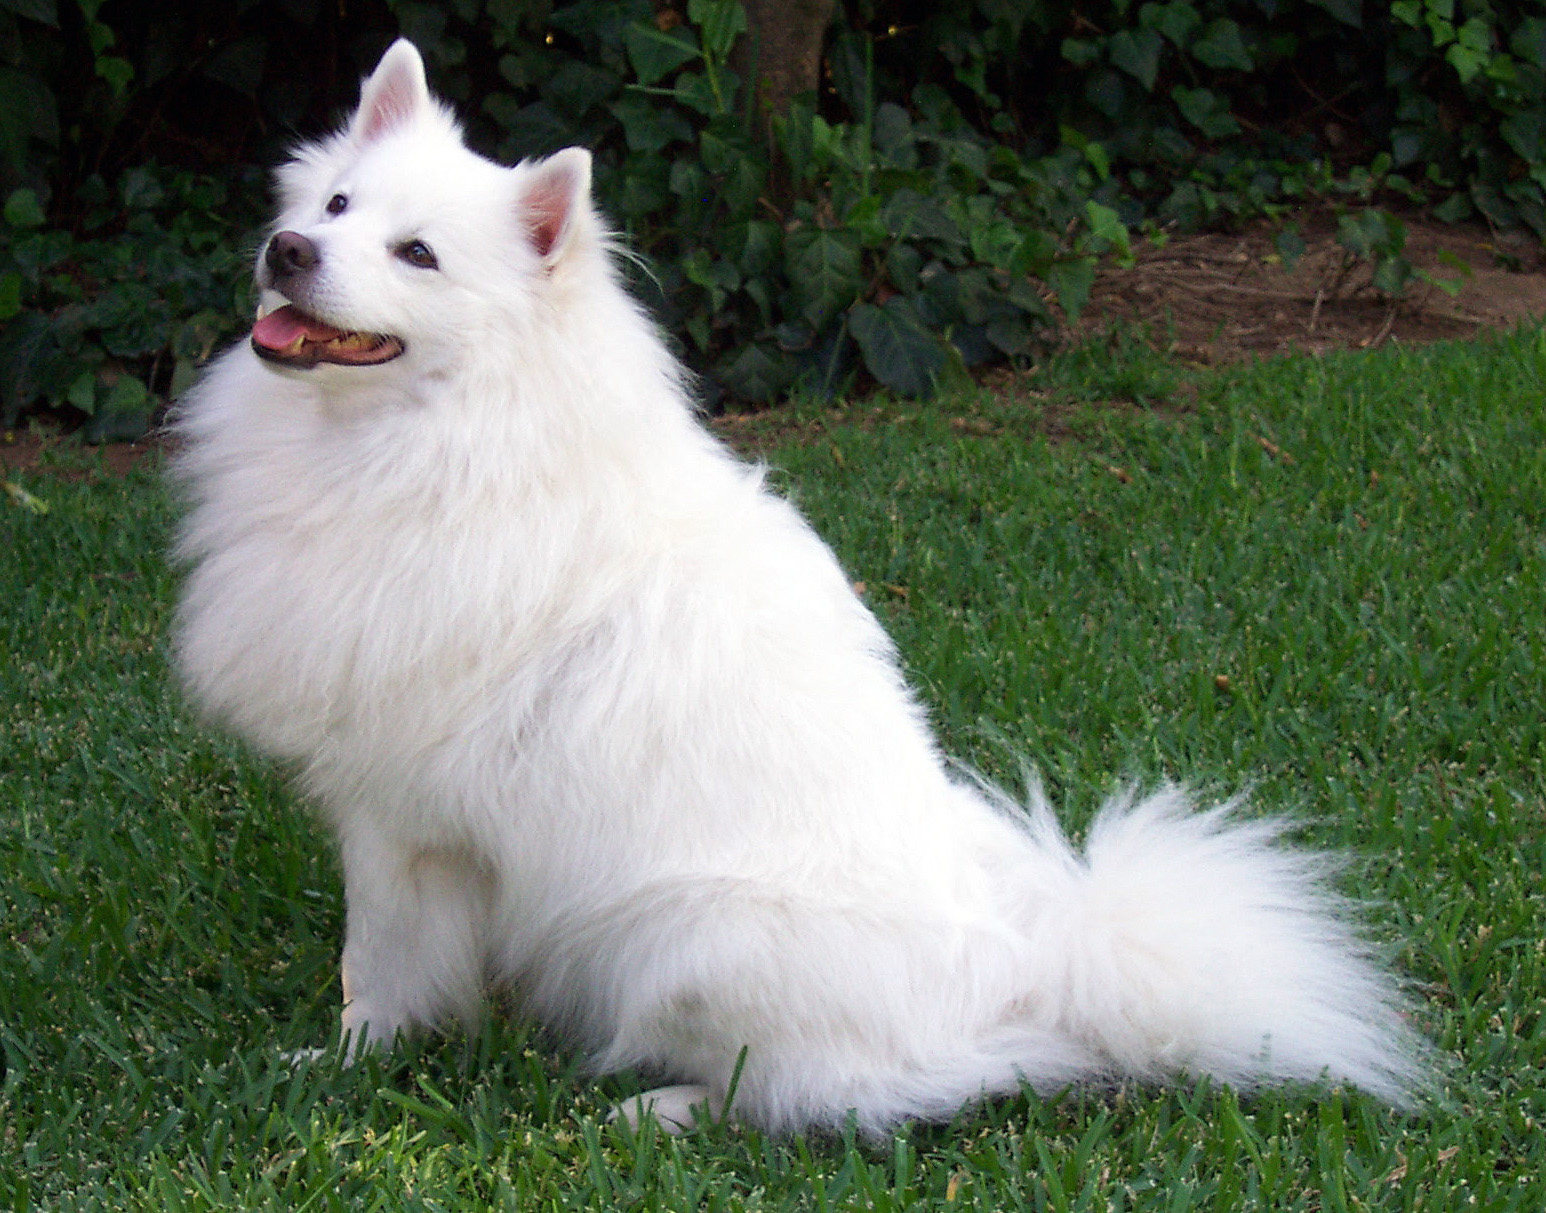

In [132]:
input_image

## Creating adversarial samples

In [92]:
%matplotlib inline

In [142]:
epsilon = torch.Tensor([0.0, 0.1, 0.15, 0.2]) # epsilon values
images_and_ids = [
    ('palace.jpeg', 968),
    ('shark.jpeg', 3),
    ('brass.jpeg', 458),
    ('fire_engine.jpeg', 555)
]
base_path = './data/samples/'

<ipython-input-144-bdca9a4537e8>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct_label = labels[int(F.softmax(output).argmax())]


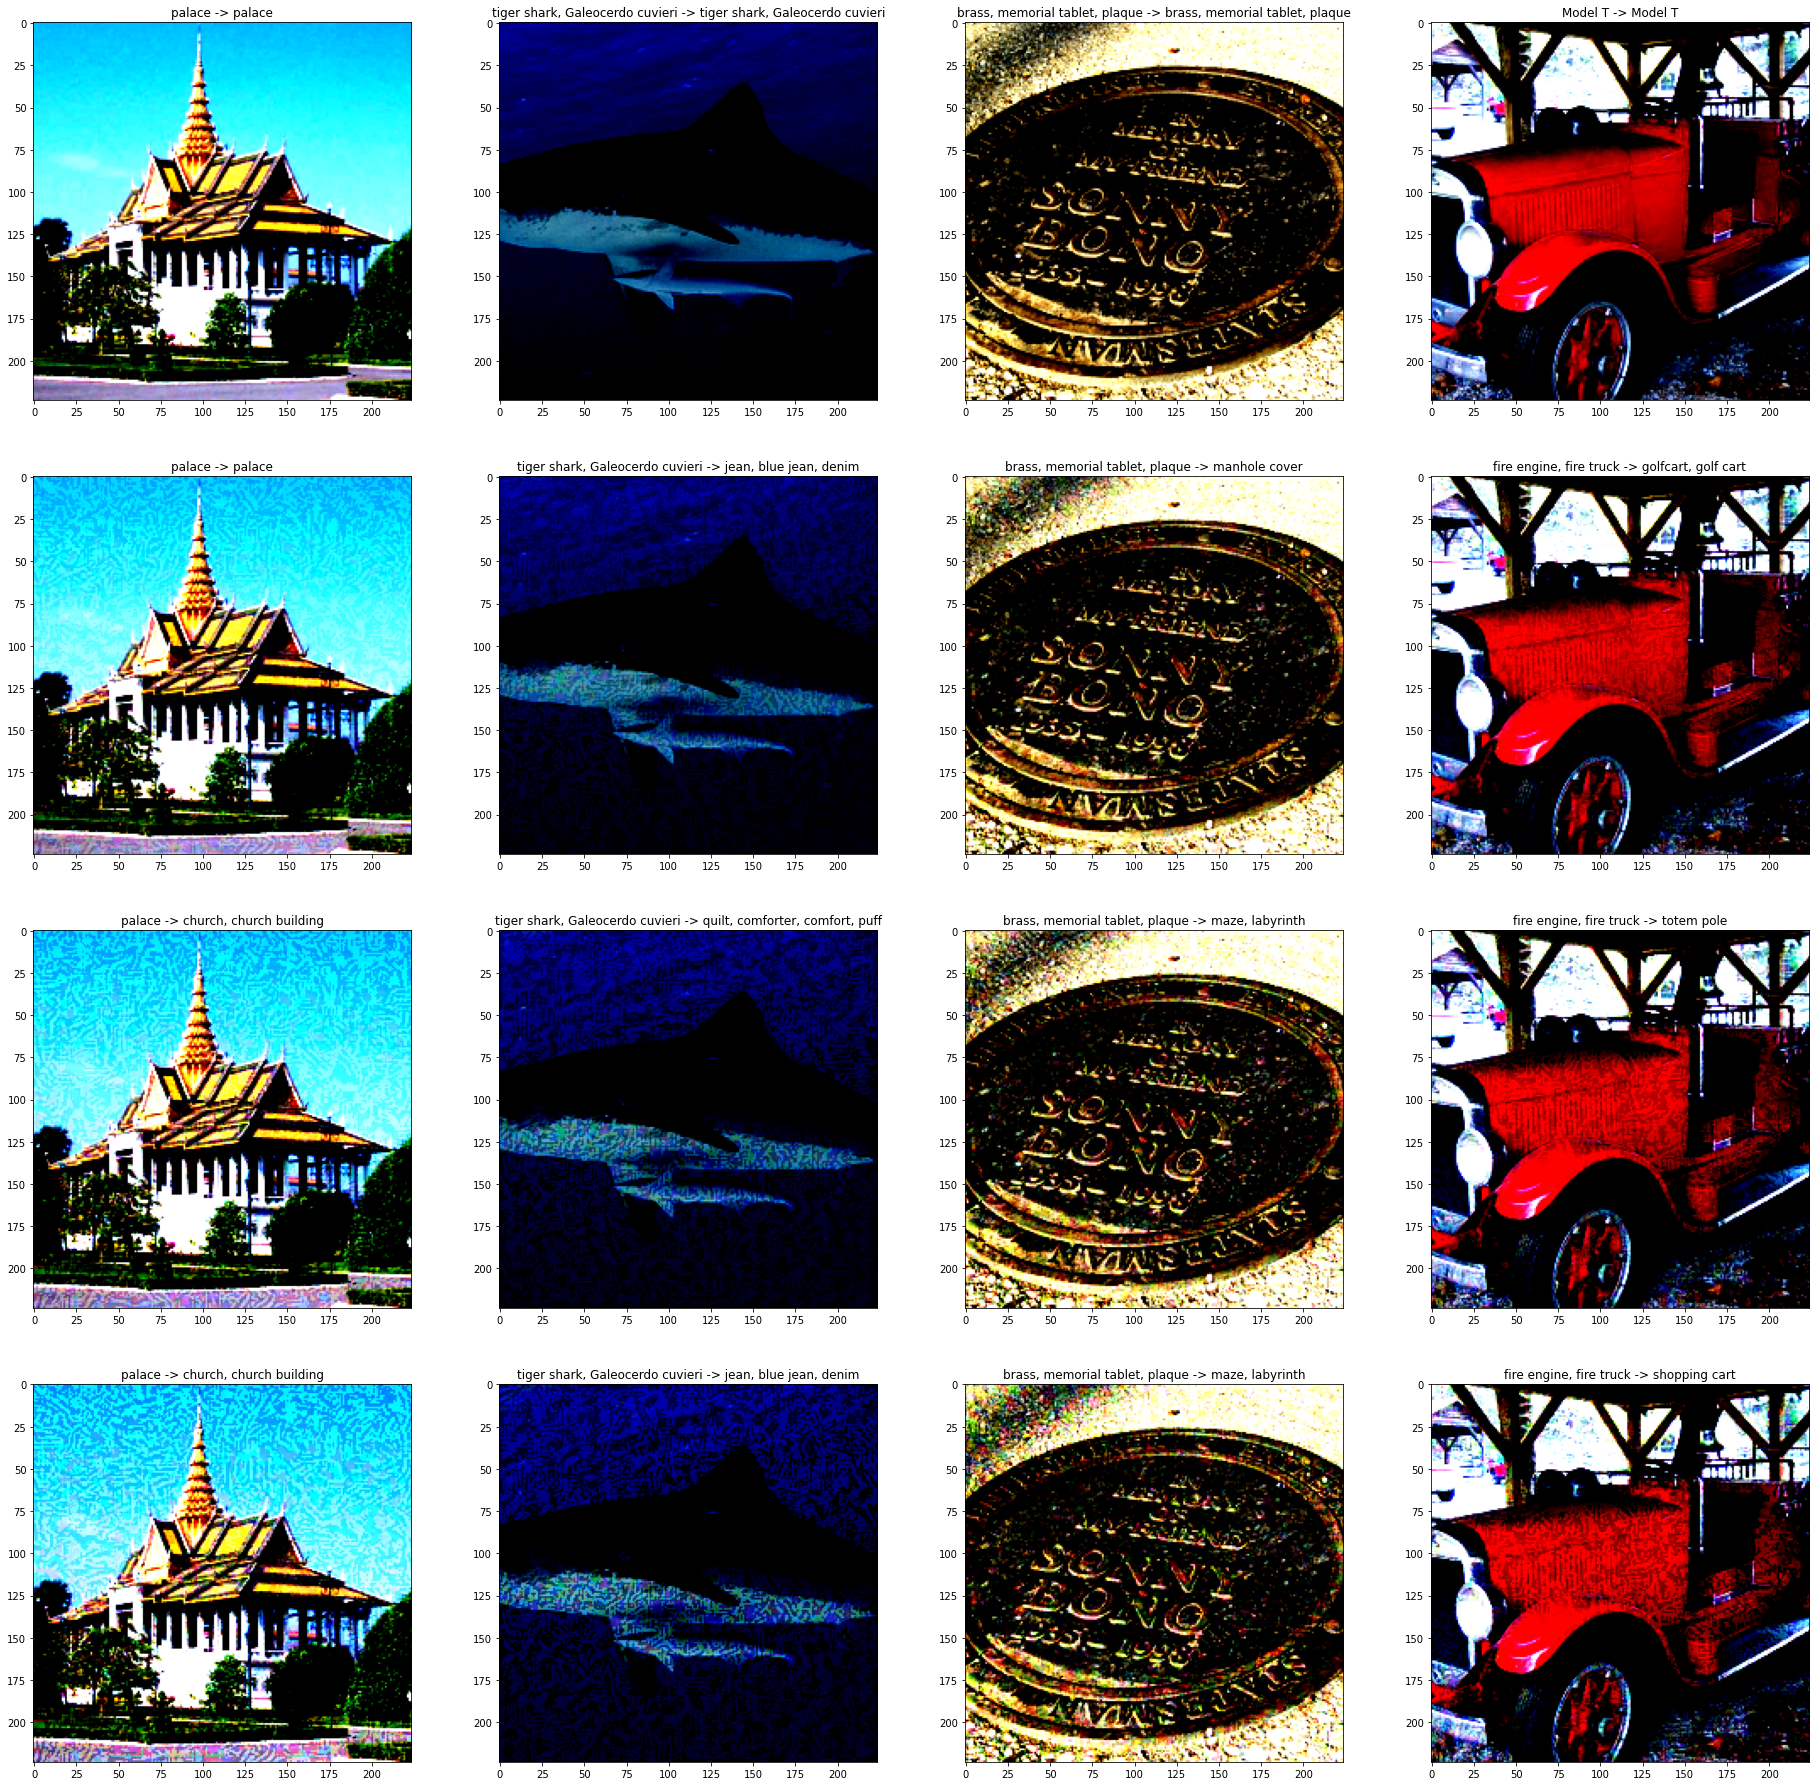

In [144]:
fig, axes = plt.subplots(nrows=len(epsilon), ncols=len(images_and_ids), figsize=(32,32))

for eps_idx, eps in enumerate(epsilon):
    for img_idx, (image_path, image_id) in enumerate(images_and_ids):
        # load the image
        full_path = base_path + image_path
        image = Image.open(full_path)
        
        # preprocess the image
        input_image = preprocess(image).unsqueeze(0)
        
        # activate gradients so we can track what happens
        input_image.requires_grad = True
        
        # feed the image to the model
        output = model(input_image)
        correct_label = labels[int(F.softmax(output).argmax())]
        
        # calculate the loss so we can have gradients, clear the model, get the grads
        target = torch.Tensor([image_id]).long()
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward() # <- super important of course
        
        # get the gradients regarding the input
        input_grads = input_image.grad.data
        
        # calculate the perturbed image with our current epsilon
        perturbed_image = input_image + eps * torch.sign(input_grads)
        perturbed_pred = model(perturbed_image)
        perturbed_label = labels[int(perturbed_pred.argmax())]
        
        # plot in our grid
        ax = axes[eps_idx, img_idx]
        ax.imshow(perturbed_image.clamp(min=0.0, max=1.0).squeeze().detach().permute(1,2,0).numpy())
        ax.set_title(f"{correct_label} -> {perturbed_label}")

## Results

You see that as we increase epsilon, our model is more and more confused about the images.
Unfortunately, reducing the image size makes the plotting look bad. So for us, even the first row seems perturbed although it starts with $\epsilon = 0.0$.

In the future, I am going to train a pretrained ResNet50-v2 on larger images and show that we can create perturbations that make the model confused and look pretty good to the user.
Stay tuned.